# Idenfication of nearest ORFs

In [132]:
import os, re, sys
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
from Bio import SeqIO
from scipy.stats import norm
from bisect import bisect_left
import seaborn as sns
sns.set_theme(style='whitegrid')

print(sys.version)

3.11.3 (main, May 15 2023, 10:43:03) [Clang 14.0.6 ]


## Parse genebank annotations

In [52]:
def parse_gb(gb):
    # get all sequence records for the specified genbank file
    recs = [rec for rec in SeqIO.parse(gb, "genbank")]
    # print the number of sequence records that were extracted
    # print(len(recs))
    # print annotations for each sequence record
    for rec in recs:
        annotation_type = rec.annotations
    # print the gene sequence feature summary information for each feature in each
    # sequence record
    dict = {}
    for rec in recs:
        feats = [feat for feat in rec.features if feat.type == "gene"]
        for feat in feats:
            locus_tag = feat.qualifiers['locus_tag']
            locus_tag = ";".join(locus_tag)
            location = feat.location
            strand = int(location.strand)
            # flip start and end if gene is on negative strand
            if strand == 1:
                start_pos = int(location.start)
                end_pos = int(location.end)
            elif strand == -1:
                start_pos = int(location.end)
                end_pos = int(location.start)
            dict.update({start_pos: (locus_tag, start_pos, end_pos, strand)})
    return dict

def make_orf_list(annotations, chrom):
    gb = os.path.join(annotations, chrom + '.gb')
    dict_chrom = parse_gb(gb)
    start_codon_list = sorted(list(dict_chrom.keys()))
    return dict_chrom, start_codon_list

annotations = "/Users/yunfei/2023_ChipSeq/annotations"
gene_dict = {}
start_codon_dict = {}
for fname, chrom in {'NZ_CP012004.1':'NZ_CP012004.1', 
                     'pAb1' : 'NC_009083.1', 
                     'pAb2' : 'NC_009084.1', 
                     'pAb3' : 'NZ_CP012005.1'}.items():
    dict_chrom, start_codon_list = make_orf_list(annotations, fname)
    gene_dict.update({chrom: dict_chrom})
    start_codon_dict.update({chrom : start_codon_list})


## Classify peak as coding or intergenic =

In [54]:
def is_intra(summit, dict, chrom):
    # return whether a peak summit is within any CDS region
    match = False # intergenic
    for key, value in dict[chrom].items():
        start = value[1]
        end = value[2]
        chrom = value[3]
        if chrom == 1:
            if start <= summit <= end: # genes can overlap, thus there might be more than 1 hit
                match = True # coding
                break
        elif chrom == -1:
            if end <= summit <= start: # on the negative strand gene positions are [end, start]
                match = True # coding
                break
    return match

## Find the nearest ORFs
### Adjacent peaks on the same strand and within 1000 bp of the peak position are reported

In [119]:
class NearestORF:
    def __init__(self, summit, gene_dict, start_codon_dict, chrom):
        self.summit = summit
        self.chrom = chrom
        self.dict_annotation = gene_dict[chrom]
        self.start_codon_list = start_codon_dict[chrom]

    def find_nearest_start_codon(self):
        match_index = bisect_left(self.start_codon_list, self.summit)
        if match_index == 0:
            nearest_match = self.start_codon_list[0]
        elif match_index == len(self.start_codon_list):
            nearest_match = self.start_codon_list[-1]
        else:
            left = self.start_codon_list[match_index - 1]
            right = self.start_codon_list[match_index]
            if right - self.summit < self.summit - left:
                nearest_match = right
            else:
                nearest_match = left
        return nearest_match

    def get_match_info(self, match_ORF, strand):
        accession, start, end, ORF_strand = self.dict_annotation[match_ORF]
        if strand == 1:
            distance_to_match = self.summit - match_ORF
        elif strand == -1:
            distance_to_match = match_ORF - self.summit
        match_info = [self.summit, 0, accession, self.chrom, start, end, ORF_strand, distance_to_match]
        return match_info

    def find_next_ORFs(self, ORF_list_to_search, strand):
        counter = 0
        next_ORFs = []
        for next_match_index in ORF_list_to_search:
            counter += 1
            next_match_strand = self.dict_annotation[next_match_index][3]
            if next_match_strand == strand:
                match_info = self.get_match_info(next_match_index, next_match_strand)
                match_info[1] = counter
                next_match_distance = match_info[7]
                if abs(next_match_distance) <= 1000:
                    next_ORFs.append(match_info)
                else:
                    break
            else:
                break
        return next_ORFs

    def nearest_orf(self):
        nearest_match = self.find_nearest_start_codon()
        nearest_match_info = self.get_match_info(nearest_match, self.dict_annotation[nearest_match][3])
        all_match = [nearest_match_info]

        if self.dict_annotation[nearest_match][3] == 1:  # If nearest ORF is on + strand, search right
            ORF_list = self.start_codon_list[bisect_left(self.start_codon_list, self.summit) + 1:]
        elif self.dict_annotation[nearest_match][3] == -1:  # If nearest ORF is on - strand, search left
            ORF_list = self.start_codon_list[:bisect_left(self.start_codon_list, self.summit)][::-1]  # List is reversed
        next_ORFs = self.find_next_ORFs(ORF_list, self.dict_annotation[nearest_match][3])

        all_match += next_ORFs
        return all_match

In [120]:
## To test NearestORF
summit = 306809
chrom = 'NZ_CP012004.1'
orf_finder = NearestORF(summit, gene_dict, start_codon_dict, chrom)
orf_finder.nearest_orf()

[[306809, 0, 'ACX60_RS01470', 'NZ_CP012004.1', 306809, 306509, -1, 0],
 [306809, 1, 'ACX60_RS01465', 'NZ_CP012004.1', 306393, 304884, -1, -416]]

In [140]:
def make_histogram(infile, outfile, distance_plot, gene_dict, start_codon_dict):
    # make histogram, and output stats to a tsv file
    df_peak = pd.read_csv(infile, sep='\t')
    distance_list_intergenic = []
    distance_list_coding = []
    match_stats = []
    for index, peak in df_peak.iterrows():
        chrom = peak['chrom']
        summit = peak['average_summit']
        fold_enrich = peak['average_enrichment']
        orf_finder = NearestORF(summit, gene_dict, start_codon_dict, chrom)
        all_ORFs = orf_finder.nearest_orf()
        for match_info in all_ORFs:
            distance = match_info[-1]
            if is_intra(summit, gene_dict, chrom):
                match_info.append('coding')
                distance_list_coding.append(distance)
            else:
                match_info.append('intergenic')
                distance_list_intergenic.append(distance)
            match_info.append(fold_enrich)
            match_stats.append(match_info)
    
    # write output to csv
    # add 'Nth nearest ORF'
    col_names = ['summit_pos', 'Nth nearest ORF', 'locus_tag', 'chrom', 'start', 'end', 'strand', 'distance_to_match', 'match_type', 'average_fold_enrichment']
    df_out = pd.DataFrame(match_stats, columns=col_names)
    df_out = df_out.sort_values(by = ['summit_pos', 'Nth nearest ORF'], ascending = [True, True])
    print(df_out.head())
    df_out.to_csv(outfile, sep='\t', index=False)
    
    # 23Mar2023 changed default bin size to 20
    #fig, ax = plt.subplots()
    ax = sns.displot(data=df_out, x='distance_to_match', hue='match_type', common_norm=True)
    ax.set(xlabel='Distance from nearest start codon (nt)',
          ylabel='Count',
          xlim=(-1000,1000),
          title=os.path.basename(infile))
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #plt.tight_layout()
    #plt.show()
    plt.savefig(distance_plot)

     summit_pos  Nth nearest ORF      locus_tag          chrom  start    end  \
4          3649                0  ACX60_RS00020  NZ_CP012004.1   3882   6351   
3          7132                0       A1S_3475    NC_009084.1   6196   8608   
417       11064                0  ACX60_RS18245  NZ_CP012005.1  10999  10429   
418       11064                1  ACX60_RS18245  NZ_CP012005.1  10999  10429   
419       11064                2  ACX60_RS18240  NZ_CP012005.1  10427   9890   

     strand  distance_to_match  match_type  average_fold_enrichment  
4         1               -233      coding                     2.95  
3         1                936      coding                     1.49  
417      -1                -65  intergenic                     4.16  
418      -1                -65  intergenic                     4.16  
419      -1               -637  intergenic                     4.16  


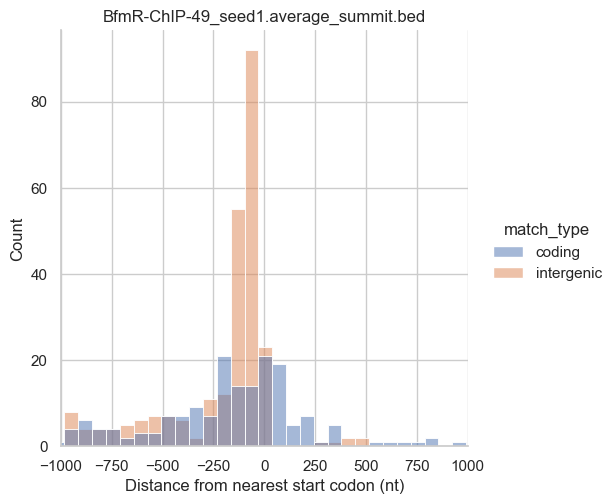

In [141]:
infile = "/Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-49_seed1.average_summit.bed"
outdir = "/Users/yunfei/2023_ChipSeq/peak_stat_next_ORFs"

os.makedirs(outdir, exist_ok=True)

outfile = os.path.join(outdir, 'test.tsv')
distance_plot = os.path.join(outdir, 'test.tiff')

make_histogram(infile, outfile, distance_plot, gene_dict, start_codon_dict)